In [3]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))

import spatial_metrics.helper_functions as hf
import spatial_metrics.detect_peaks as dp

import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.spatial_metrics_1d_calcium_base as pl


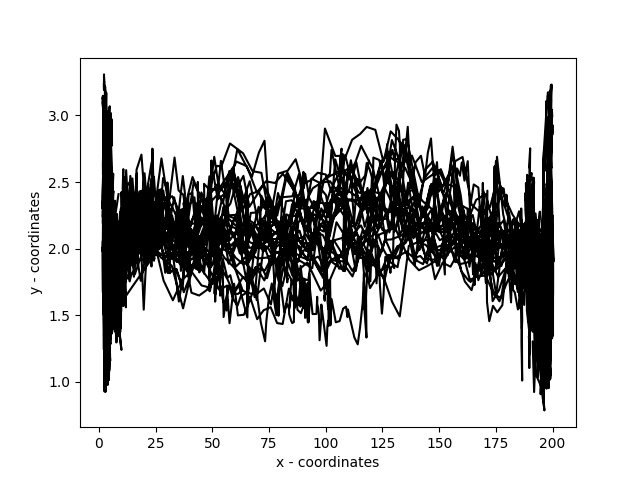

In [4]:
import pandas as pd
os.chdir('/home/apolo/Documents/github_projects/information_metrics/data/hanna/')

environment_edges = [[0,200],[0,4]] 

time_vector = np.load('time_vector.pickle',allow_pickle=True)
x_coordinates = np.load('x_coordinates.pickle',allow_pickle=True)
y_coordinates = np.load('y_coordinates.pickle',allow_pickle=True)
sampling_rate = 1/np.nanmean(np.diff(time_vector))

# Load the pickle file using pandas
df = pd.read_pickle('traces_neuron8.pickle')
signal = np.array(df)
signal_norm = hf.min_max_norm(signal,custom_min=0,custom_max=1)

peaks_idx = dp.detect_peaks(signal,mpd=0.1*sampling_rate,mph=0.*np.nanstd(signal))

plt.close('all')
plt.figure()
plt.plot(x_coordinates, y_coordinates,'k')
plt.xlabel('x - coordinates')
plt.ylabel('y - coordinates')
# plt.gca().set_aspect('equal', 'box')
plt.show()


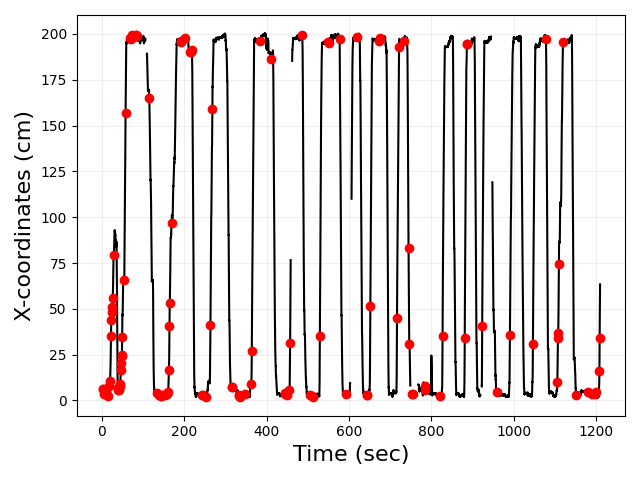

In [5]:
peaks_idx = dp.detect_peaks(signal,mpd=0*sampling_rate,mph=0.*np.nanstd(signal))

plt.figure()
plt.plot(time_vector, x_coordinates,color = 'black')
plt.plot(time_vector[peaks_idx], x_coordinates[peaks_idx],color = 'red',linestyle='',marker='o',markersize=6)

plt.ylabel('X-coordinates (cm)',fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


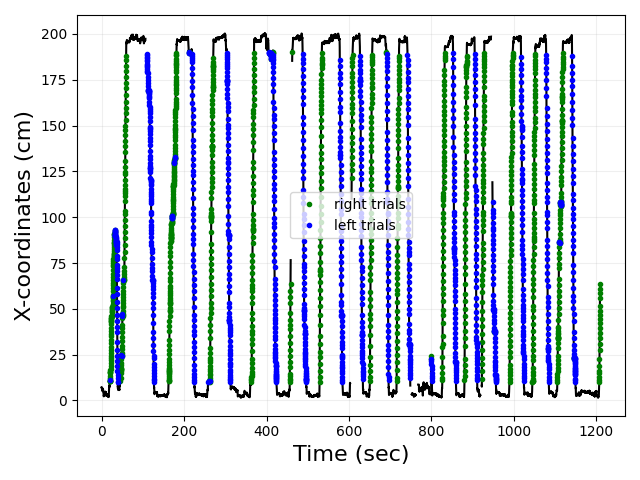

In [6]:

threshold_right = 1
threshold_left = -1

trials_idx = (x_coordinates >= 10) & (x_coordinates <= 190)

velocity,velocity_smoothed = hf.get_velocity_1D(x_coordinates, time_vector,sigma_points=1)

velocity_right_idx = (velocity_smoothed > threshold_right)
velocity_left_idx = (velocity_smoothed < threshold_left)

trials_idx*velocity_right_idx
trials_idx*velocity_left_idx

plt.figure()
plt.plot(time_vector, x_coordinates,color = 'black')
plt.plot(time_vector[trials_idx*velocity_right_idx], x_coordinates[trials_idx*velocity_right_idx],'g.',label = 'right trials')
plt.plot(time_vector[trials_idx*velocity_left_idx], x_coordinates[trials_idx*velocity_left_idx],'b.',label = 'left trials')
plt.legend()

plt.ylabel('X-coordinates (cm)',fontsize=16)
plt.xlabel('Time (sec)',fontsize=16)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [7]:
# video sampling rate (it can be an approximation of the coordinates timestamps for cameras with varying frame rates)
# sampling_rate = 1/np.nanmean(np.diff(time_vector))

# now input_signal will point to the signal you choose
signal_type = 'Raw'
input_signal = hf.min_max_norm(signal,custom_min=0,custom_max=1)

# signal_type = 'Filtered'
# input_signal = filtered_signal

# signal_type = 'Diff'
# input_signal = diff_signal

# signal_type = 'Diff_truncated'
# input_signal = diff_signal_truncated

input_dict = dict()

# filename constructor
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type
input_dict['animal_id'] = 'NeuronModel'
input_dict['dataset'] = 'Simulation'
input_dict['day'] = 1
input_dict['neuron'] = 1
input_dict['trial'] = None
input_dict['saving_path'] = None
input_dict['saving'] = False
 
input_dict['sampling_rate'] = sampling_rate # in points per second
input_dict['environment_edges'] = environment_edges # in cm

# inclusion criteria
input_dict['min_time_spent'] = 0
input_dict['min_visits'] = 0
input_dict['min_speed_threshold'] = 0 
input_dict['speed_smoothing_points'] = int(np.round(0.1*sampling_rate)) # speed gaussian smoothing in seconds

# information parameters
input_dict['x_bin_size'] = 2 # x bin size in cm
input_dict['nbins_cal'] = 10

# surrogate parameters
input_dict['shift_time'] = 200
input_dict['num_cores'] = -1
input_dict['num_surrogates'] = 800

# place field parameters
input_dict['smoothing_size'] = 2
input_dict['percentile_threshold'] = 99
input_dict['min_num_of_pixels'] = 2


# run across all trials
place_cell = pl.PlaceCell(**input_dict)
place_cell_output = place_cell.main(input_signal,time_vector,x_coordinates)


# run across right trials
trials = trials_idx*velocity_right_idx
place_cell_output_right_trials = place_cell.main(input_signal[trials],time_vector[trials],x_coordinates[trials])


# # run across left trials
trials = trials_idx*velocity_left_idx
place_cell_output_left_trials = place_cell.main(input_signal[trials],time_vector[trials],x_coordinates[trials])


SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved
SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved
SpatialMetrics.Raw.NeuronModel.Dataset.Simulation.Day.1.Neuron.1 not saved


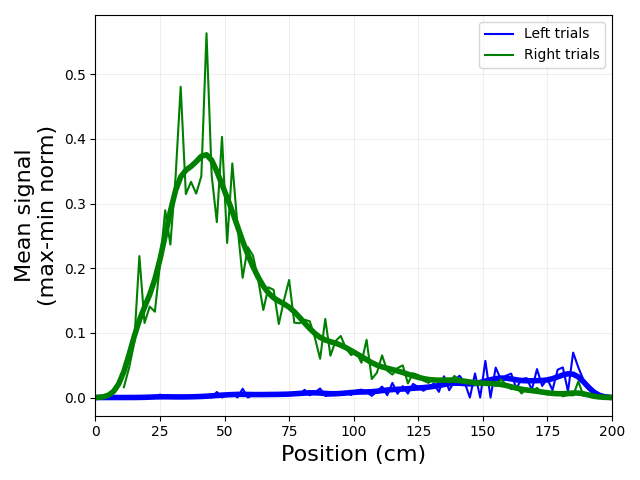

In [8]:


place_field_smoothed_left = place_cell_output_left_trials['place_field_smoothed'].copy()
place_field_left = place_cell_output_left_trials['place_field']

place_field_smoothed_right = place_cell_output_right_trials['place_field_smoothed'].copy()
place_field_right = place_cell_output_right_trials['place_field']


plt.figure()
plt.plot(place_cell_output_left_trials['x_center_bins'],place_field_left,'b',label='Left trials')
plt.plot(place_cell_output_left_trials['x_center_bins'],place_field_smoothed_left,'b',linewidth=4)

plt.plot(place_cell_output_right_trials['x_center_bins'],place_field_right,'g',label='Right trials')
plt.plot(place_cell_output_right_trials['x_center_bins'],place_field_smoothed_right,'g',linewidth=4)
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


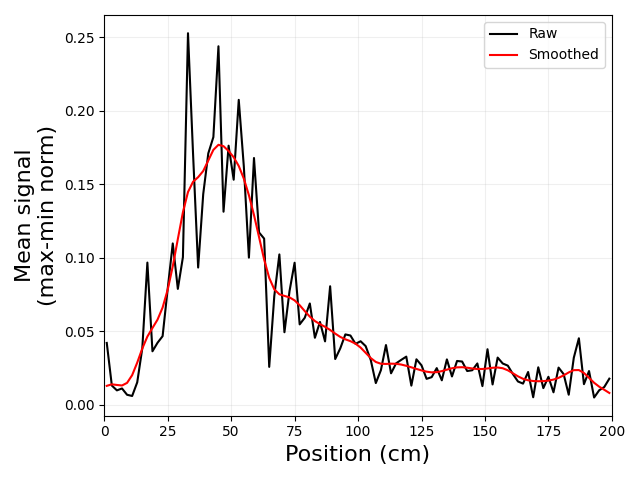

In [9]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


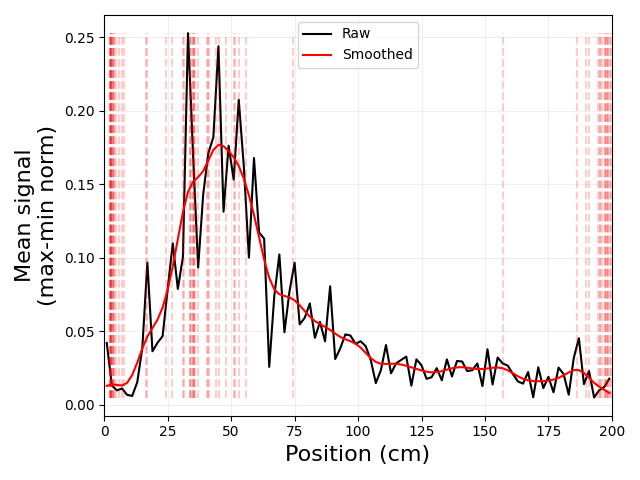

In [10]:


plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
plt.plot([place_cell_output['x_peaks_location'],place_cell_output['x_peaks_location']],[np.nanmin(place_cell_output['place_field']),np.nanmax(place_cell_output['place_field'])],color = 'red',linestyle='--',alpha=0.2)
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


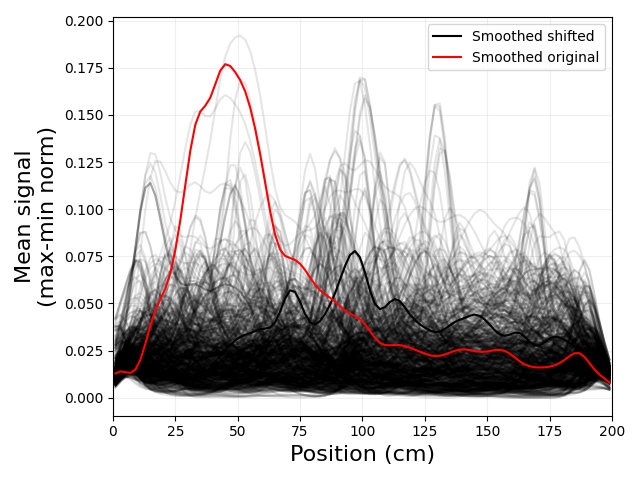

In [11]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed_shifted'][0,:],color = 'black',label='Smoothed shifted',alpha=1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()

plt.tight_layout()
plt.show()


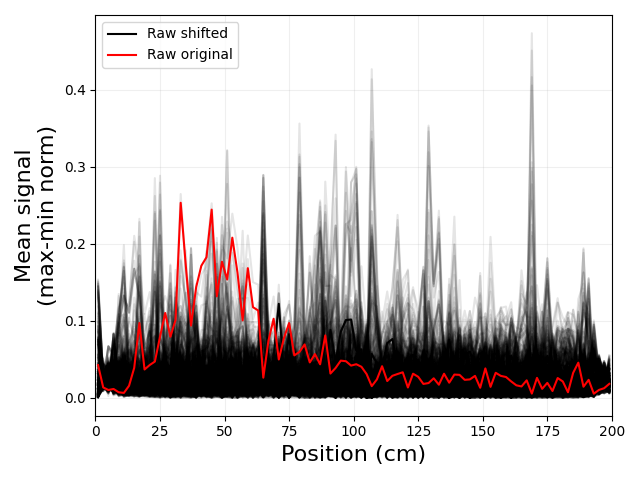

In [12]:

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'].T,color = 'black',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_shifted'][0,:],color = 'black',label='Raw shifted',alpha=1)
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'red',label='Raw original')
plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


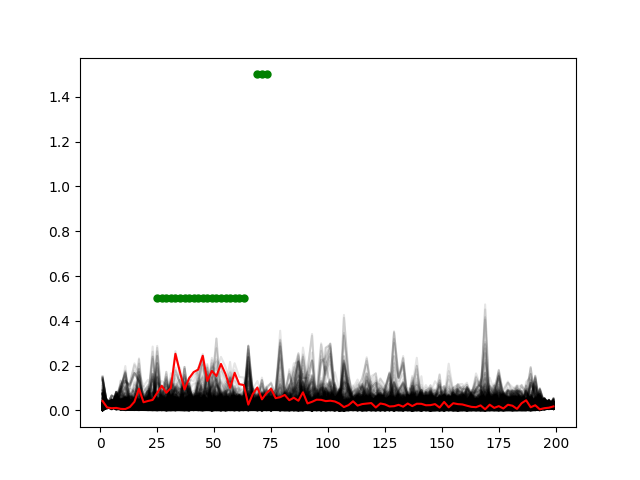

In [13]:

place_field_smoothed_shifted = place_cell_output['place_field_shifted'].copy()
place_field_smoothed = place_cell_output['place_field'].copy()
place_field_identity = place_cell_output['place_field_identity']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed_shifted.T,'k',alpha=0.1)
plt.plot(place_cell_output['x_center_bins'],place_field_smoothed,'r')
plt.plot(place_cell_output['x_center_bins'],place_field_identity+0.5,'g.',markersize=10)
plt.show()


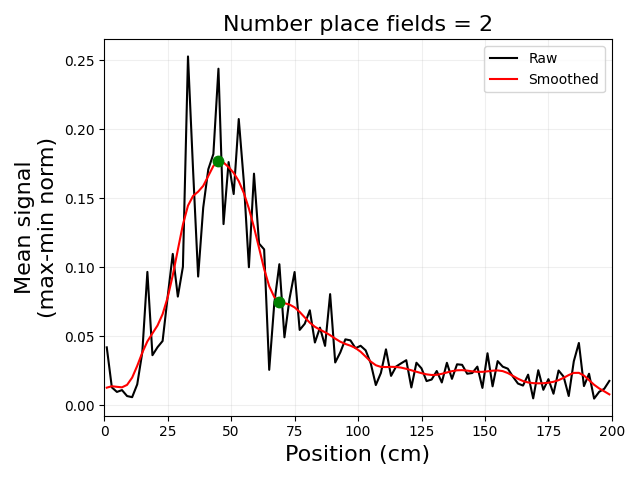

In [14]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()



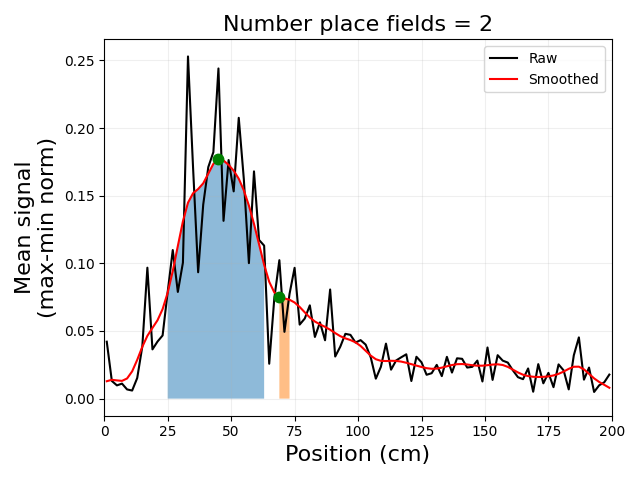

In [15]:

place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field'],color = 'black',label='Raw')
plt.plot(place_cell_output['x_center_bins'],place_cell_output['place_field_smoothed'],color = 'red',label='Smoothed')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.xlabel('Position (cm)',fontsize=16)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylabel('Mean signal\n(max-min norm)',fontsize=16)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_cell_output['place_field_smoothed'],0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]),alpha=0.5)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()




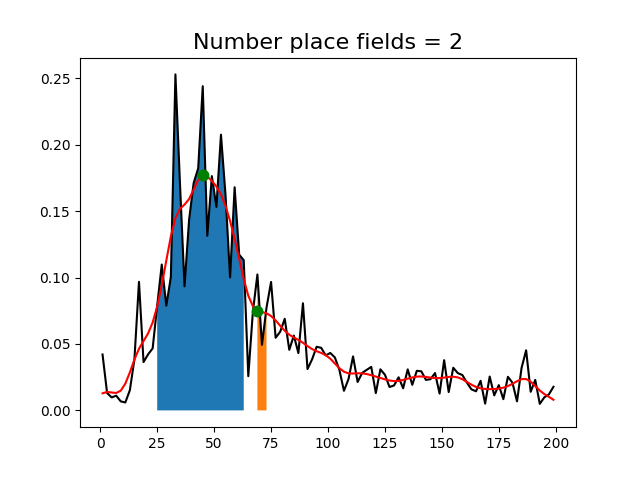

In [16]:

place_field = place_cell_output['place_field'].copy()
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_identity = place_cell_output['place_field_identity']
x_center_bins = place_cell_output['x_center_bins']
islands_x_max = place_cell_output['islands_x_max']

plt.figure()
plt.plot(x_center_bins,place_field,'k')
plt.plot(x_center_bins,place_field_smoothed,'r')
if islands_x_max.size>0:
    plt.plot(x_center_bins[islands_x_max],place_field_smoothed[islands_x_max],'g.',markersize=15)

plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)

for ii in range(place_cell_output['num_of_islands']):
    field_spread = place_cell_output['x_center_bins'][place_field_identity == ii]
    plt.fill_between(x_center_bins,place_field,0,where = (x_center_bins >= field_spread[0]) & (x_center_bins <= field_spread[-1]))
plt.show()


In [30]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']

array([0.19])

In [29]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.19])

In [66]:
place_cell_output['mutual_info_shifted'].shape[0]/10

80.0

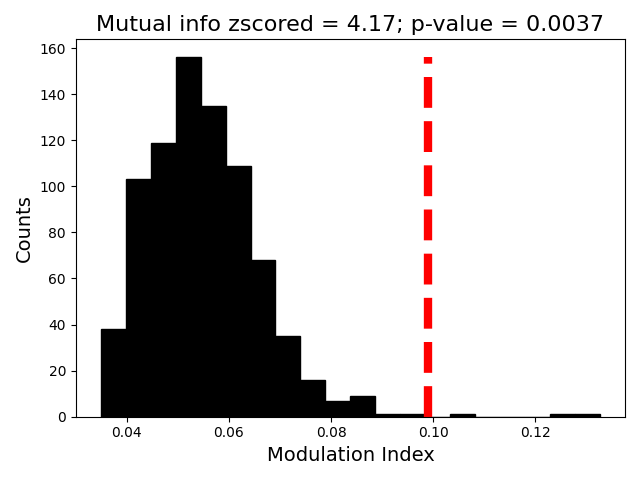

In [17]:
# p value is defined as the amount of shifted mutual information values above the original one 
p_value = np.sum(place_cell_output['mutual_info_shifted'] >= place_cell_output['mutual_info_original'])/place_cell_output['mutual_info_shifted'].shape[0]

if p_value == 0:
    p_value = 1/place_cell_output['mutual_info_shifted'].shape[0]
p_value

counts,bins = np.histogram(place_cell_output['mutual_info_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['mutual_info_original'],place_cell_output['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mutual info zscored = {0:.2f}; p-value = {1:.4f}".format(place_cell_output['mutual_info_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


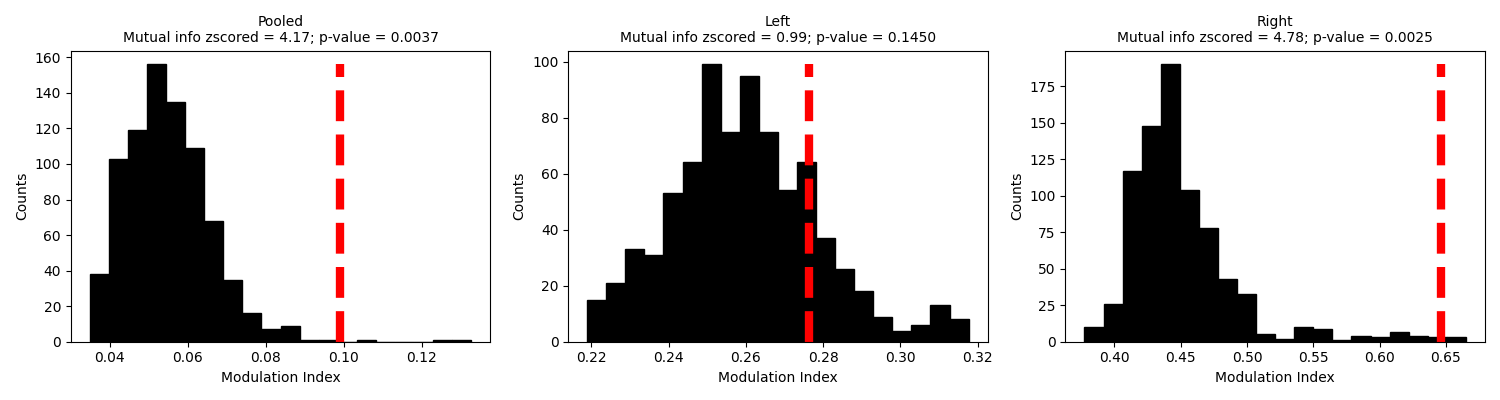

In [18]:
# if you want to compare left, right and pooled trials
pooled_dicts = [place_cell_output,place_cell_output_left_trials,place_cell_output_right_trials]
pooled_labels = ['Pooled','Left','Right']
plt.figure(figsize=(15,4))

for counter,place_cell_output_in_use in enumerate(pooled_dicts):

    # p value is defined as the amount of shifted mutual information values above the original one 
    p_value = np.sum(place_cell_output_in_use['mutual_info_shifted'] >= place_cell_output_in_use['mutual_info_original'])/place_cell_output_in_use['mutual_info_shifted'].shape[0]
    
    if p_value == 0:
        p_value = 1/place_cell_output_in_use['mutual_info_shifted'].shape[0]
    p_value
    
    counts,bins = np.histogram(place_cell_output_in_use['mutual_info_shifted'],20)
    bins_centers = bins[0:-1] + np.diff(bins)
    bin_width = np.diff(bins_centers)[0]
    
    plt.subplot(1,3,counter+1)
    plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
    plt.plot([place_cell_output_in_use['mutual_info_original'],place_cell_output_in_use['mutual_info_original']],[0,np.max(counts)],'r--',linewidth=6)
    plt.title(pooled_labels[counter] + "\nMutual info zscored = {0:.2f}; p-value = {1:.4f}".format(place_cell_output_in_use['mutual_info_zscored'],p_value),fontsize=10)
    plt.xlabel('Modulation Index',fontsize=10)
    plt.ylabel('Counts',fontsize=10)
    

plt.tight_layout()
plt.show()
